# Solving subset sum on a trapped ion quantum computer

This notebook records the results of solving the subset sum problem on a trapped ion quantum computer provided by IONQ, using Microsoft's Azure Quantum service.

In [1]:
from azure.quantum.qiskit import AzureQuantumProvider
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

provider = AzureQuantumProvider (
    resource_id = "/subscriptions/b0c3bbe3-7123-4ba4-9aa2-57d9845f4a1d/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/qchack-2022-b",
    location = "westus"
)

print("This workspace's targets:")
for backend in provider.backends():
    print("- " + backend.name())

This workspace's targets:
Opening in existing browser session.


libva error: vaGetDriverNameByIndex() failed with unknown libva error, driver_name = (null)
[176711:176711:0100/000000.695221:ERROR:sandbox_linux.cc(377)] InitializeSandbox() called with multiple threads in process gpu-process.


- ionq.qpu
- ionq.simulator
- quantinuum.hqs-lt-s1
- quantinuum.hqs-lt-s1-apival
- quantinuum.hqs-lt-s2
- quantinuum.hqs-lt-s2-apival
- quantinuum.hqs-lt-s1-sim
- quantinuum.hqs-lt-s2-sim


In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

In [3]:
from subset_sum_solver import SubsetSumSolver

We solve the problem $A=[5,7,8,9,1] , target=16$. The feasible sets are 01101 and 01010 as bitstrings.

As in the *grover_search_test* notebook, let's start with a single Grover iteration.

In [4]:
I = QuantumRegister(5)
V = QuantumRegister(5)
A = QuantumRegister(1)
R = ClassicalRegister(5)

circ = SubsetSumSolver(16, [5, 7, 8, 9, 1], 1, I, V, A, R)

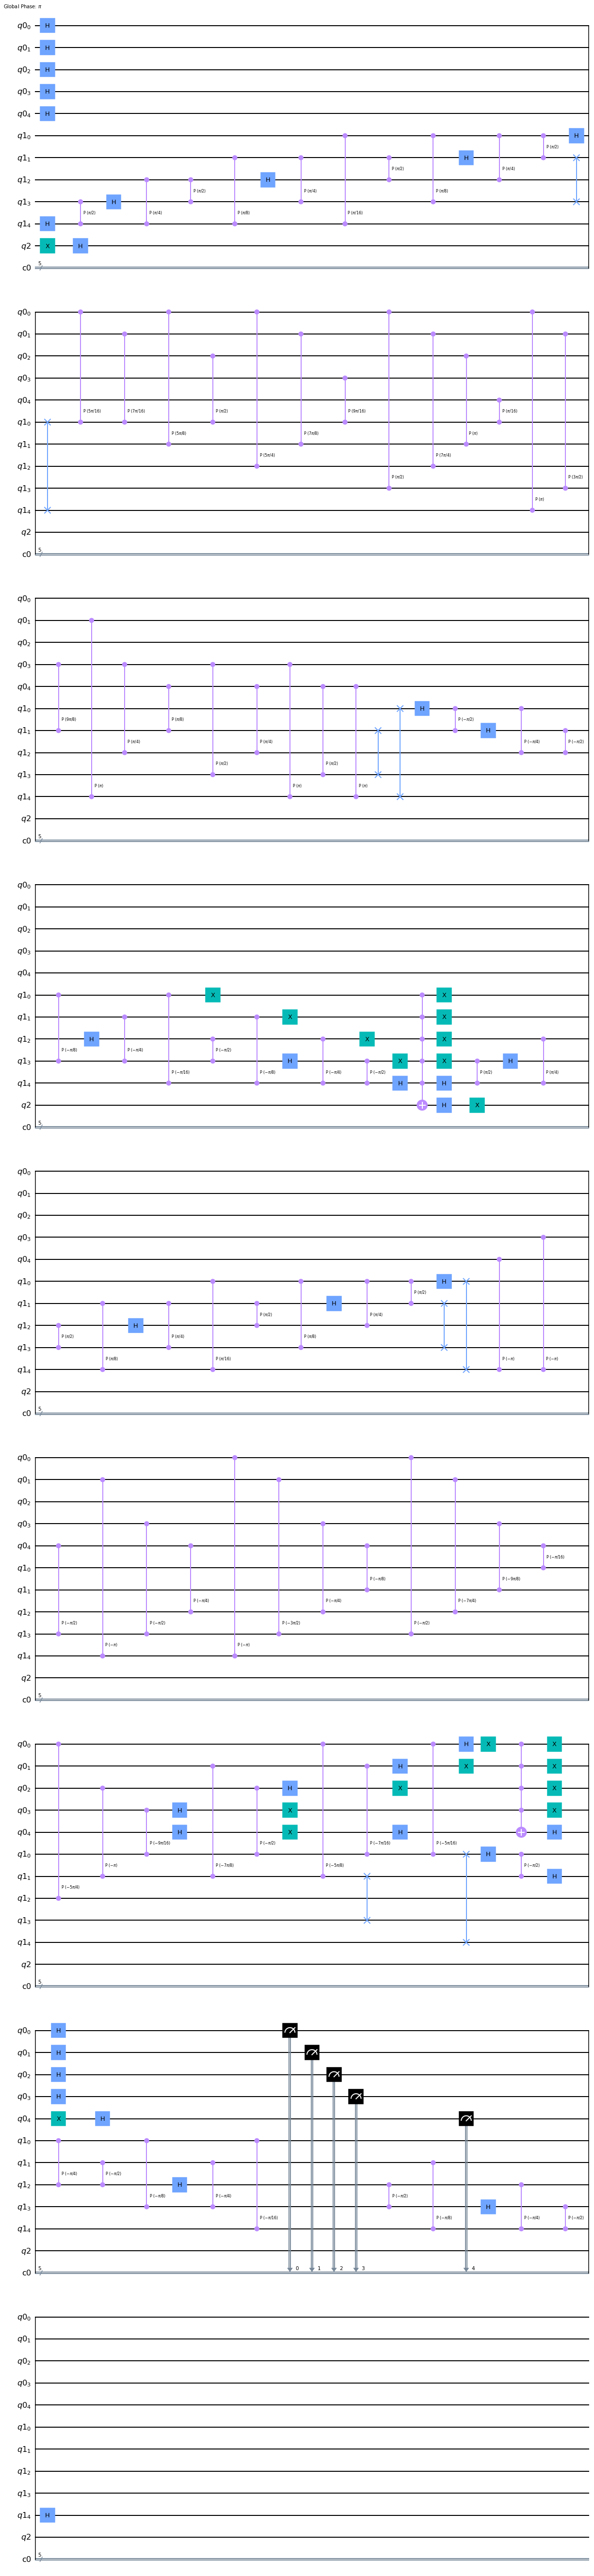

In [5]:
circ.draw("mpl")

In [8]:
backend = provider.get_backend("ionq.qpu")

In [9]:
cost = backend.estimate_cost(circ, shots=50)
print(f"Estimated cost: {cost.estimated_total} {cost.currency_code}")

Estimated cost: 1.8104999999999996 USD


In [10]:
job = backend.run(circ, shots=50)

In [11]:
print(f"Job id : {job.id()}")

Job id : 0ef38d22-b870-11ec-b84a-9843fa02ff35


In [12]:
job_monitor(job)

Job Status: job has successfully run


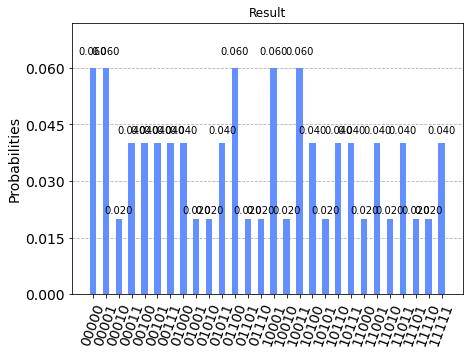

In [13]:
result = job.result()
plot_histogram(result.get_counts(circ), title="Result")

The probabiliy amplification hasn't had much effect. More number of shots might also improve our statistics. Let's try 3 iterations with 200 shots.

In [14]:
circ = SubsetSumSolver(16, [5, 7, 8, 9, 1], 3, I, V, A, R)

In [16]:
cost = backend.estimate_cost(circ, shots=200)
print(f"Estimated cost: {cost.estimated_total} {cost.currency_code}")

Estimated cost: 21.666 USD


In [17]:
job = backend.run(circ, shots=200)
print(f"Job id : {job.id()}")

Job id : f6047028-b87a-11ec-b84a-9843fa02ff35


In [18]:
job_monitor(job)

Job Status: job has successfully run


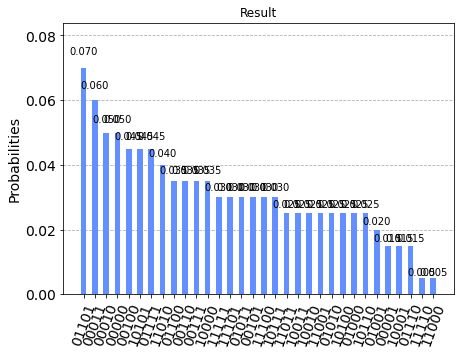

In [23]:
result = job.result()
plot_histogram(result.get_counts(circ), title="Result", sort='value_desc')

This looks a little better. Notice that the mode 01101 is a feasible set. However the other feasible set is not as likely for some reason.

Moreover, in real uses cases where we don't know the actual feasible sets, it's not enough for the solutions to be modes. Rather they should have high mass. This goes to show the effect of noise on the resulting statistics, and hence computation. Smaller Grover iterations don't favor feasible solutions much, and larger iterations makes circuits longer and vulnerable to noise.